<a href="https://colab.research.google.com/github/RuslanDulaev/prediction_of_price_with_indicators/blob/main/indicators_for_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Установка необходимых библиотек

In [1]:
pip install tinkoff-investments

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.9/239.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.6 which is incompatible.


In [2]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=ec8280adcee431f75a86f4c433a63fb97f9497df871ea5868f1a6b4a83c93bef
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


## Импорт библиотек

In [3]:
from datetime import datetime, timedelta
import pandas as pd
from ta.trend import ema_indicator, macd
from ta.momentum import rsi, stoch
from ta.volatility import bollinger_hband, bollinger_lband, average_true_range
from ta.volume import on_balance_volume

In [4]:
from tinkoff.invest import Client, RequestError, CandleInterval, HistoricCandle
from tinkoff.invest.services import InstrumentsService, MarketDataService

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

## Создание переменной с API-токеном

In [6]:
token_to_read = 't.uglxvjKCO20qYdAeFmQt9FHSUGpe7FlY7jY_U4GEb5-6xm6POKUdFzvD11yZ31RSOnkj_cbBXQMoPe6N13bjrA'

## Инициализация списка с тикерами

In [7]:
TICKER = ['SNGS' 'ROSN', 'IRAO', 'NVTK', 'RUAL', 'YNDX', 'TATN', 'PLZL', 'LKOH', 'CHMF',
          'GAZP', 'GMKN', 'NLMK', 'SBER', 'MGNT', 'MTLRP', 'MTLR', 'FIVE', 'AFLT', 'GLTR',
          'UPRO', 'CBOM', 'VTBR', 'FLOT', 'ENPG', 'AGRO', 'AFKS', 'ALRS', 'TRNFP', 'MAGN',
          'TCSG', 'QIWI', 'VKCO', 'POLY', 'SMLT', 'TATNF', 'SNGSP', 'PHOR', 'PIKK', 'SELG',
          'RTKM', 'OZON', 'MOEX', 'POSI', 'FEES', 'MSNG', 'HYDR', 'SGZH', 'RNFT', 'IRKT',
          'MTSS', 'SBERP', 'TATNP', 'UWGN', 'DSKY', 'MVID', 'APTK', 'DELI', 'TRMK', 'BANE',
          'BSPB', 'ROLO', 'LENT', 'KMAZ', 'TTLK', 'SFIN', 'EUTR', 'FESH', 'SIBN', 'ETLN',
          'WUSH', 'ASTR', 'UGLD', 'NMTP', 'SPBE', 'LSRG', 'SVCB', 'TGKN', 'FIXP', 'BANEP',
          'GEMC', 'CARM', 'GECO', 'TGKA', 'MRKZ', 'KZOSP', 'RTKMP', 'AQUA', 'ABIO', 'UNAC',
          'GTRK', 'RENI', 'MSRS', 'SOFL', 'ELFV', 'RASP', 'HNFG', 'OGKB', 'MDMG', 'LIFE',
          'MRKC', 'TGKB', 'LSNGP', 'CIAN', 'BELU', 'SVAV', 'MRKY', 'MGKL', 'NKNCP', 'MRKP',
          'MRKV', 'KZOS', 'OKEY', 'DIAS', 'YAKG', 'MRKU', 'CNTL', 'ABRD', 'PRFN', 'TGKBP',
          'GCHE', 'LSNG', 'VEON', 'AKRN', 'BLNG', 'MSTT', 'MGTSP', 'NKNC', 'KLSB', 'PMSBP',
          'AMEZ', 'DVEC', 'CNTLP', 'PMSB', 'MRKS', 'NSVZ', 'LNZLP', 'KROT', 'VSMO', 'NKHP',
          'KAZT', 'CHMK', 'RKKE', 'LNZL', 'VRSB', 'KAZTP', 'UNKL', 'KRKNP']

## Функции для взаимодействия с биржей

In [8]:
def figi_by_ticker():  # Функция для получениия figi тикеров
    dic = {}
    with Client(token_to_read) as cl:
        instruments: InstrumentsService = cl.instruments

        for method in ['shares']:
            for item in getattr(instruments, method)().instruments:
                if item.ticker in TICKER:
                    dic[item.ticker] = item.figi

    return dic

In [9]:
def cast_money(v):  # Функция для преобразования полученных чисел в удобный формат
    return v.units + v.nano / 1e9

In [10]:
def create_df(candles: [HistoricCandle]):  # Функция для создания датафрейма
    df = pd.DataFrame([{
        'time': c.time,
        'volume': c.volume,
        'open': cast_money(c.open),
        'close': cast_money(c.close),
        'high': cast_money(c.high),
        'low': cast_money(c.low),
    } for c in candles])

    return df

In [50]:
def candles(figi):  # Функция для получения свечей с московской биржи
    current_date = datetime.now().date()
    desired_time = datetime.combine(current_date, datetime.strptime('10:00', '%H:%M').time())
    with Client(token_to_read) as client:
        x = client.market_data.get_candles(
            figi=figi,
            from_=datetime.utcnow() - timedelta(days=10),
            to=datetime.utcnow(),
            interval=CandleInterval.CANDLE_INTERVAL_15_MIN
            )
    df = create_df(x.candles)
    df['price_delta'] = ((df['close'] - df['open']) / df['open']) * 100
    df['ema'] = ema_indicator(close=df['close'], window=9)
    df['rsi'] = rsi(close=df['close'], window=9)
    df['macd'] = macd(close=df['close'])
    df['bollinger_hband'] = bollinger_hband(close=df['close'], window=20)
    df['bollinger_lband'] = bollinger_lband(close=df['close'], window=20)
    df['atr'] = average_true_range(high=df['high'], low=df['low'], close=df['close'], window=14)
    df['obv'] = on_balance_volume(close=df['close'], volume=df['volume'])
    df['stoch'] = stoch(high=df['high'], low=df['low'], close=df['close'], window=14, smooth_window=3)
    return df

## Функция для формирования индикатора на основе фракталов

In [15]:
def is_fractal_up(df, i):
    if i < 2 or i > len(df) - 3:
        return False
    return (df['high'][i] > df['high'][i-1] and
            df['high'][i] > df['high'][i-2] and
            df['high'][i] > df['high'][i+1] and
            df['high'][i] > df['high'][i+2])

def is_fractal_down(df, i):
    if i < 2 or i > len(df) - 3:
        return False
    return (df['low'][i] < df['low'][i-1] and
            df['low'][i] < df['low'][i-2] and
            df['low'][i] < df['low'][i+1] and
            df['low'][i] < df['low'][i+2])

def add_fractals(df):
    df['fractal_up'] = [is_fractal_up(df, i) for i in range(len(df))]
    df['fractal_down'] = [is_fractal_down(df, i) for i in range(len(df))]
    return df

## Функция для масштабировния признаков

In [114]:
from sklearn.preprocessing import MinMaxScaler

def scale_features(df, columns):
    scaler = MinMaxScaler().fit(df[columns])
    df[columns] = scaler.transform(df[columns])
    return df

## Получение фиги (уникальных идентификаторов) тикеров

In [97]:
figies = figi_by_ticker()

In [98]:
print(figies)

{'LIFE': 'TCS10A0JR514', 'IRKT': 'BBG000FWGSZ5', 'VSMO': 'BBG004S68CV8', 'UNAC': 'BBG000Q7ZZY2', 'VKCO': 'TCS00A106YF0', 'TTLK': 'BBG000RJL816', 'MGNT': 'BBG004RVFCY3', 'SVCB': 'TCS00A0ZZAC4', 'ETLN': 'BBG001M2SC01', 'KZOSP': 'BBG0029SG1C1', 'WUSH': 'TCS00A105EX7', 'GEMC': 'TCS00A107JE2', 'UGLD': 'TCS00A0JPP37', 'PHOR': 'BBG004S689R0', 'HNFG': 'TCS00A106XF2', 'LNZL': 'BBG000SK7JS5', 'SELG': 'BBG002458LF8', 'TATNP': 'BBG004S68829', 'PRFN': 'TCS00A0JNXF9', 'MAGN': 'BBG004S68507', 'VTBR': 'BBG004730ZJ9', 'CARM': 'TCS00A105NV2', 'RUAL': 'BBG008F2T3T2', 'NKHP': 'BBG00BGKYH17', 'BANEP': 'BBG004S686N0', 'OKEY': 'BBG00172J7S9', 'ALRS': 'BBG004S68B31', 'MRKP': 'BBG000VG1034', 'FLOT': 'BBG000R04X57', 'DIAS': 'TCS00A107ER5', 'TATN': 'BBG004RVFFC0', 'SPBE': 'TCS60A0JQ9P9', 'ABIO': 'TCS10A0JNAB6', 'DVEC': 'BBG000V07CB8', 'RTKM': 'BBG004S682Z6', 'MTSS': 'BBG004S681W1', 'TGKN': 'BBG000RG4ZQ4', 'TRNFP': 'BBG00475KHX6', 'FEES': 'BBG00475JZZ6', 'PMSB': 'BBG000MZL0Y6', 'MSRS': 'BBG004S687G6', 'IRAO': 'BB

## Создание словаря для хранения датафреймов с ценами каждой из акций

In [116]:
shares = {}

In [117]:
for ticker in figies:
  shares[ticker] = candles(figies[ticker])

## Добавление индикатора с фракталом в датафреймы

In [118]:
for ticker in figies:
  shares[ticker] = add_fractals(shares[ticker])

In [119]:
shares['MGNT']

,time,volume,open,close,high,low,price_delta,ema,rsi,macd,bollinger_hband,bollinger_lband,atr,obv,stoch,fractal_up,fractal_down
0,2025-03-19 13:00:00+00:00,14115,4974.0,4972.5,4978.5,4963.5,-0.030157,NaN,NaN,NaN,NaN,NaN,0.000000,14115,NaN,False,False
1,2025-03-19 13:15:00+00:00,12129,4972.5,4962.0,4975.0,4957.5,-0.211161,NaN,NaN,NaN,NaN,NaN,0.000000,1986,NaN,False,False
2,2025-03-19 13:30:00+00:00,9251,4961.5,4950.0,4964.0,4944.5,-0.231785,NaN,NaN,NaN,NaN,NaN,0.000000,-7265,NaN,False,True
3,2025-03-19 13:45:00+00:00,8984,4949.5,4965.0,4967.5,4948.0,0.313163,NaN,NaN,NaN,NaN,NaN,0.000000,1719,NaN,False,False
4,2025-03-19 14:00:00+00:00,8835,4965.0,4962.0,4970.0,4953.0,-0.060423,NaN,NaN,NaN,NaN,NaN,0.000000,-7116,NaN,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719,2025-03-29 12:00:00+00:00,544,4387.0,4382.0,4387.5,4382.0,-0.113973,4386.536824,38.394490,-9.676319,4404.683521,4370.716479,13.663740,-817618,37.662338,False,False
720,2025-03-29 12:15:00+00:00,13319,4382.0,4365.0,4382.5,4348.0,-0.387951,4382.229459,26.688829,-10.780826,4403.048763,4368.201237,15.152044,-830937,30.909091,False,True
721,2025-03-29 12:30:00+00:00,2333,4364.0,4371.0,4371.5,4362.5,0.160403,4379.983567,34.605183,-11.044689,4402.971321,4366.278679,14.712613,-828604,49.462366,False,False
722,2025-03-29 12:45:00+00:00,1867,4371.0,4371.0,4373.5,4370.0,0.000000,4378.186854,34.605183,-11.125554,4403.143472,4365.906528,13.911712,-826737,49.462366,False,False


## Создание дополнительных серий для формирования зависимой переменной

In [120]:
for ticker in shares:
  shares[ticker]['future_price'] = shares[ticker]['close'].shift(-4)

In [121]:
print(shares['MGNT'])

                         time  volume    open   close    high     low  \
0   2025-03-19 13:00:00+00:00   14115  4974.0  4972.5  4978.5  4963.5   
1   2025-03-19 13:15:00+00:00   12129  4972.5  4962.0  4975.0  4957.5   
2   2025-03-19 13:30:00+00:00    9251  4961.5  4950.0  4964.0  4944.5   
3   2025-03-19 13:45:00+00:00    8984  4949.5  4965.0  4967.5  4948.0   
4   2025-03-19 14:00:00+00:00    8835  4965.0  4962.0  4970.0  4953.0   
..                        ...     ...     ...     ...     ...     ...   
719 2025-03-29 12:00:00+00:00     544  4387.0  4382.0  4387.5  4382.0   
720 2025-03-29 12:15:00+00:00   13319  4382.0  4365.0  4382.5  4348.0   
721 2025-03-29 12:30:00+00:00    2333  4364.0  4371.0  4371.5  4362.5   
722 2025-03-29 12:45:00+00:00    1867  4371.0  4371.0  4373.5  4370.0   
723 2025-03-29 13:00:00+00:00      47  4371.0  4370.5  4371.0  4370.5   

     price_delta          ema        rsi       macd  bollinger_hband  \
0      -0.030157          NaN        NaN        NaN

In [122]:
for ticker in shares:
  shares[ticker]['future_price_up_1%'] = shares[ticker]['close'] + shares[ticker]['close'] * 0.005
  shares[ticker]['future_price_down_1%'] = shares[ticker]['close'] - shares[ticker]['close'] * 0.005

## Инициализация зависимой переменной

In [123]:
for ticker in shares:
  shares[ticker]['change_of_price'] = 0

In [124]:
for ticker in shares:
  shares[ticker].loc[((shares[ticker]['future_price'] >= shares[ticker]['future_price_up_1%']) \
       & (shares[ticker]['close'] < shares[ticker]['future_price_up_1%'])), 'change_of_price'] = 1 # Цена поднялась
  shares[ticker].loc[((shares[ticker]['future_price'] <= shares[ticker]['future_price_down_1%']) \
       & (shares[ticker]['close'] > shares[ticker]['future_price_down_1%'])), 'change_of_price'] = 2 # Цена опустилась

## Удаление нулевых значений

In [125]:
for ticker in shares:
  shares[ticker] = shares[ticker].dropna()

## Масштабирование признаков для каждой из акций




In [126]:
numeric_columns = shares['MGNT'].drop(columns=['time', 'fractal_up', 'fractal_down', 'change_of_price']).columns
numeric_columns

Index(['volume', 'open', 'close', 'high', 'low', 'price_delta', 'ema', 'rsi',
       'macd', 'bollinger_hband', 'bollinger_lband', 'atr', 'obv', 'stoch',
       'future_price', 'future_price_up_1%', 'future_price_down_1%'],
      dtype='object')

In [127]:
for ticker in shares:
  shares[ticker] = scale_features(shares[ticker], numeric_columns)

<ipython-input-114-17b68231bc22>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns] = scaler.transform(df[columns])


## Формирование датафрейма со всеми ценами акций

In [130]:
all_data = pd.DataFrame()
for ticker in shares:
  all_data = pd.concat([all_data, shares[ticker]])



---



In [131]:
all_data

,time,volume,open,close,high,low,price_delta,ema,rsi,macd,...,bollinger_lband,atr,obv,stoch,fractal_up,fractal_down,future_price,future_price_up_1%,future_price_down_1%,change_of_price
25,2025-03-19 19:30:00+00:00,0.000127,0.891304,0.924731,0.891304,0.900000,0.384700,0.930400,0.540468,0.781825,...,0.964295,0.260701,0.394087,0.750000,False,False,0.956989,0.924731,0.924731,0
26,2025-03-19 19:45:00+00:00,0.000127,0.923913,0.924731,0.891304,0.930000,0.315562,0.933342,0.540468,0.785274,...,0.966925,0.220584,0.394178,0.750000,False,False,0.956989,0.924731,0.924731,0
27,2025-03-19 20:15:00+00:00,0.009498,0.923913,0.924731,0.891304,0.930000,0.315562,0.935696,0.540468,0.786690,...,0.968464,0.183333,0.398733,0.750000,False,False,0.967742,0.924731,0.924731,0
28,2025-03-19 20:30:00+00:00,0.000317,0.934783,0.935484,0.902174,0.940000,0.315562,0.939912,0.598080,0.794561,...,0.968885,0.161191,0.398914,0.875000,False,False,0.978495,0.935484,0.935484,0
29,2025-03-19 20:45:00+00:00,0.013868,0.923913,0.956989,0.923913,0.930000,0.384456,0.947950,0.698580,0.815466,...,0.969119,0.165528,0.405551,1.000000,False,False,0.967742,0.956989,0.956989,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,2025-03-29 07:15:00+00:00,0.000000,0.133333,0.126866,0.096774,0.133333,0.487258,0.163183,0.375602,0.602946,...,0.076762,0.330961,0.251854,0.057143,False,False,0.112676,0.126866,0.126866,2
400,2025-03-29 07:30:00+00:00,0.000567,0.133333,0.089552,0.096774,0.096296,0.405393,0.134949,0.321667,0.527589,...,0.065682,0.322927,0.251517,0.000000,False,False,0.112676,0.089552,0.089552,0
401,2025-03-29 07:45:00+00:00,0.000567,0.088889,0.067164,0.058065,0.074074,0.454381,0.105997,0.290219,0.453057,...,0.046369,0.305119,0.251180,0.000000,False,False,0.140845,0.067164,0.067164,0
402,2025-03-29 08:00:00+00:00,0.002834,0.074074,0.059701,0.045161,0.066667,0.470798,0.080713,0.279298,0.390632,...,0.029659,0.278234,0.249831,0.000000,False,False,0.105634,0.059701,0.059701,0


## Undersampling

In [132]:
target_count = min(all_data['change_of_price'].value_counts().min(), 7700)

df_0 = all_data[all_data['change_of_price'] == 0].sample(n=target_count, random_state=42)
df_1 = all_data[all_data['change_of_price'] == 1].sample(n=target_count, random_state=42)
df_2 = all_data[all_data['change_of_price'] == 2].sample(n=target_count, random_state=42)

all_data_balanced = pd.concat([df_0, df_1, df_2])

all_data_balanced = all_data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(all_data_balanced['change_of_price'].value_counts())

change_of_price
2    7700
1    7700
0    7700
Name: count, dtype: int64


In [133]:
all_data_balanced

,time,volume,open,close,high,low,price_delta,ema,rsi,macd,...,bollinger_lband,atr,obv,stoch,fractal_up,fractal_down,future_price,future_price_up_1%,future_price_down_1%,change_of_price
0,2025-03-20 13:15:00+00:00,0.023587,0.926471,0.895522,0.933824,0.899281,0.590548,0.913782,0.577100,0.632529,...,0.935453,0.691826,0.660913,0.633333,False,False,0.850746,0.895522,0.895522,2
1,2025-03-25 07:45:00+00:00,0.011817,0.524752,0.509804,0.480769,0.585106,0.481896,0.572081,0.504598,0.676578,...,0.506824,0.300496,0.308202,0.437500,False,False,0.458716,0.509804,0.509804,2
2,2025-03-27 14:00:00+00:00,0.061628,0.469178,0.493639,0.497056,0.482609,0.595495,0.484123,0.639542,0.719967,...,0.504182,0.472230,0.383266,0.730769,True,False,0.428329,0.493639,0.493639,2
3,2025-03-25 17:30:00+00:00,0.010955,0.719547,0.718750,0.688705,0.710602,0.375015,0.714634,0.708904,0.537626,...,0.691845,0.411913,0.450216,0.861538,False,False,0.767045,0.718750,0.718750,1
4,2025-03-27 08:00:00+00:00,0.040248,0.580902,0.557029,0.580902,0.555556,0.350566,0.590646,0.268462,0.492201,...,0.614347,0.304366,0.550585,0.290909,False,False,0.444444,0.557029,0.557029,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23095,2025-03-22 04:30:00+00:00,0.000390,0.748820,0.740357,0.708758,0.762681,0.423810,0.766789,0.330971,0.400675,...,0.795006,0.176033,0.701488,0.150685,False,False,0.786453,0.740357,0.740357,1
23096,2025-03-26 20:30:00+00:00,0.049343,0.449289,0.457820,0.453510,0.462928,0.591924,0.460436,0.442793,0.269338,...,0.486850,0.367247,0.579578,0.195122,False,False,0.387524,0.457820,0.457820,2
23097,2025-03-27 12:30:00+00:00,0.027967,0.185185,0.179104,0.148387,0.185185,0.487258,0.143943,0.522727,0.495180,...,0.221370,0.089546,0.032609,0.400000,False,False,0.225352,0.179104,0.179104,0
23098,2025-03-28 17:15:00+00:00,0.000000,0.253289,0.272436,0.220820,0.328402,0.574778,0.207055,0.606638,0.761484,...,0.112313,0.602146,0.718165,0.343137,False,False,0.259615,0.272436,0.272436,0


## Визуализация матриц корреляций

In [134]:
all_data_for_heatmap = all_data_balanced.drop(columns=['time', 'open', 'close', 'high', 'low', 'future_price', 'future_price_up_1%', 'future_price_down_1%'])

<Axes: >

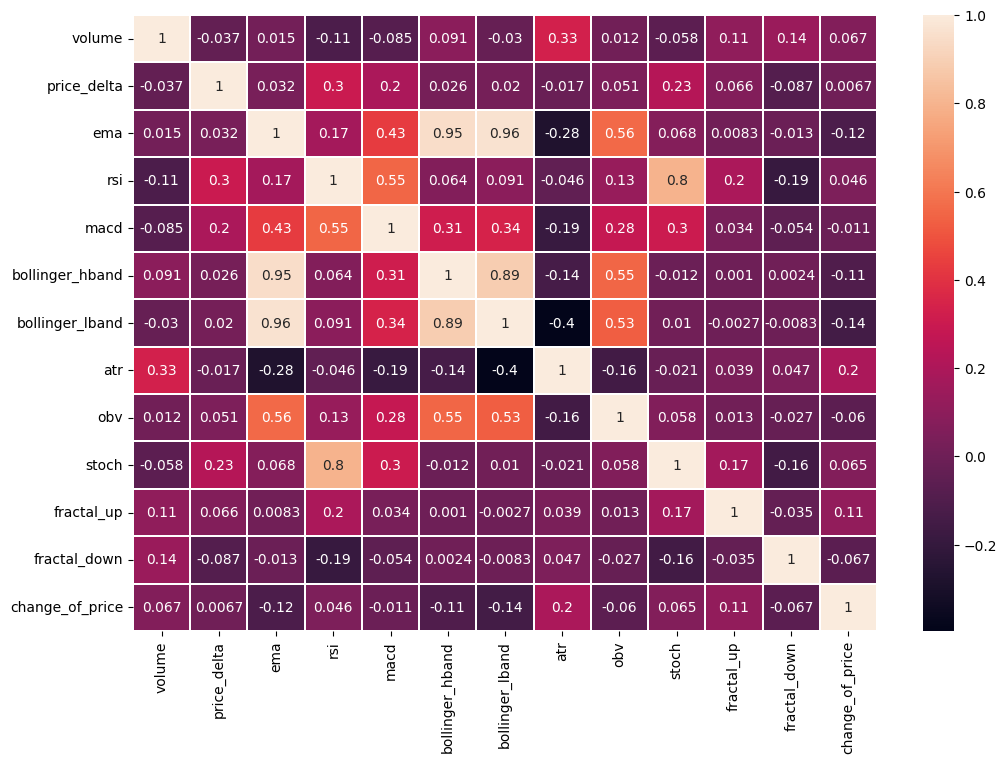

In [135]:
plt.figure(figsize=(12, 8))
sns.heatmap(data=all_data_for_heatmap.corr(), annot=True, linewidths=0.05)

## Разделение данных на предикторы и целевую переменную

In [136]:
X = all_data_balanced.drop(columns=['time', 'open', 'close', 'high', 'low', 'future_price', 'future_price_up_1%', 'future_price_down_1%', 'change_of_price'])
y = all_data_balanced['change_of_price']

In [137]:
X

,volume,price_delta,ema,rsi,macd,bollinger_hband,bollinger_lband,atr,obv,stoch,fractal_up,fractal_down
0,0.023587,0.590548,0.913782,0.577100,0.632529,0.886349,0.935453,0.691826,0.660913,0.633333,False,False
1,0.011817,0.481896,0.572081,0.504598,0.676578,0.504024,0.506824,0.300496,0.308202,0.437500,False,False
2,0.061628,0.595495,0.484123,0.639542,0.719967,0.492915,0.504182,0.472230,0.383266,0.730769,True,False
3,0.010955,0.375015,0.714634,0.708904,0.537626,0.685515,0.691845,0.411913,0.450216,0.861538,False,False
4,0.040248,0.350566,0.590646,0.268462,0.492201,0.561381,0.614347,0.304366,0.550585,0.290909,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
23095,0.000390,0.423810,0.766789,0.330971,0.400675,0.692746,0.795006,0.176033,0.701488,0.150685,False,False
23096,0.049343,0.591924,0.460436,0.442793,0.269338,0.469423,0.486850,0.367247,0.579578,0.195122,False,False
23097,0.027967,0.487258,0.143943,0.522727,0.495180,0.034385,0.221370,0.089546,0.032609,0.400000,False,False
23098,0.000000,0.574778,0.207055,0.606638,0.761484,0.190471,0.112313,0.602146,0.718165,0.343137,False,False


In [138]:
y

,change_of_price
0,2
1,2
2,2
3,1
4,2
...,...
23095,1
23096,2
23097,0
23098,0


## Разбиение данных на train и test сеты

In [139]:
from sklearn.model_selection import train_test_split

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [141]:
y_train.value_counts()

,count
change_of_price,
1,6192
0,6159
2,6129


In [142]:
y_test.value_counts()

,count
change_of_price,
2,1571
0,1541
1,1508


## Обучение на основе RandomForestClassifier

In [143]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

## Подбор наилучших гипперпараметров

In [144]:
model = RandomForestClassifier()

parametrs = {'criterion': ['gini', 'entropy'], 'max_depth': [25], 'min_samples_split': range(2, 4), 'min_samples_leaf': range(2, 4)}

In [145]:
grid_search_clf = GridSearchCV(model, parametrs, cv=5)
grid_search_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [25],
                         'min_samples_leaf': range(2, 4),
                         'min_samples_split': range(2, 4)})

In [146]:
grid_search_clf.best_params_

{'criterion': 'gini',
 'max_depth': 25,
 'min_samples_leaf': 2,
 'min_samples_split': 3}

In [147]:
best_model = grid_search_clf.best_estimator_

In [148]:
best_model.score(X_train, y_train)

0.9962662337662338

In [149]:
best_model.score(X_test, y_test)

0.5984848484848485

In [150]:
y_pred = best_model.predict(X_test)

## Вывод классификационного отчета

In [151]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.51      0.54      1541
           1       0.63      0.63      0.63      1508
           2       0.59      0.65      0.62      1571

    accuracy                           0.60      4620
   macro avg       0.60      0.60      0.60      4620
weighted avg       0.60      0.60      0.60      4620



## Визуализация матрицы ошибок

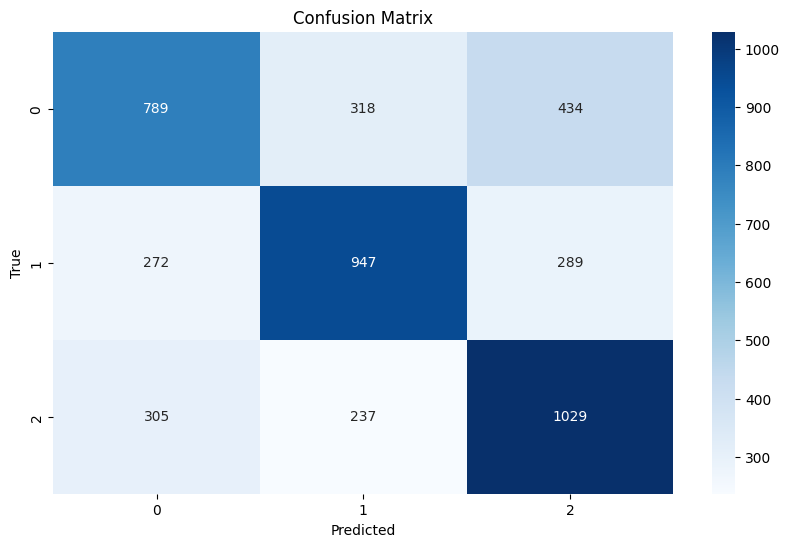

In [152]:
plt.figure(figsize=(10, 6))
cm = confusion_matrix(y_test, best_model.predict(X_test))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## Визуализация важности признаков в модели RandomForestClassifier

<ipython-input-153-ce74b610bc3a>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_importance_df['Importance'][:10], y=rf_importance_df['Feature'][:10], palette='viridis')


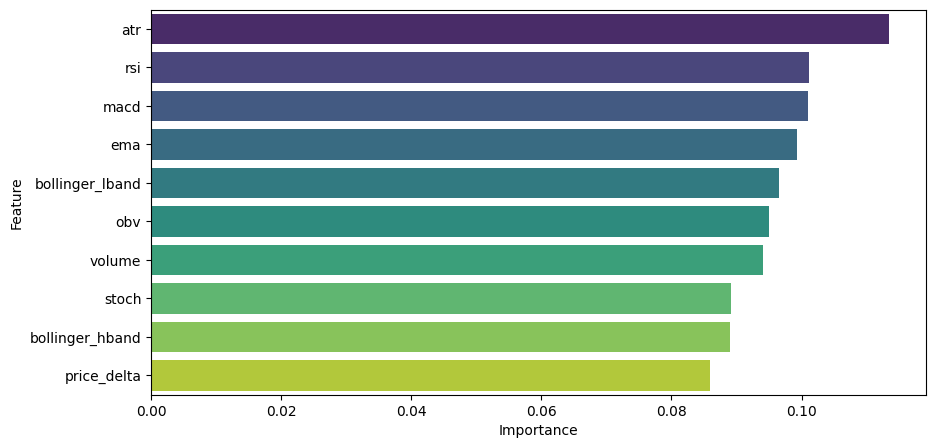

In [153]:
rf_importance = best_model.feature_importances_
rf_features = X.columns
rf_importance_df = pd.DataFrame({'Feature': rf_features, 'Importance': rf_importance}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=rf_importance_df['Importance'][:10], y=rf_importance_df['Feature'][:10], palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Визуализация подбора параметра max_depth для RandomForestClassifier

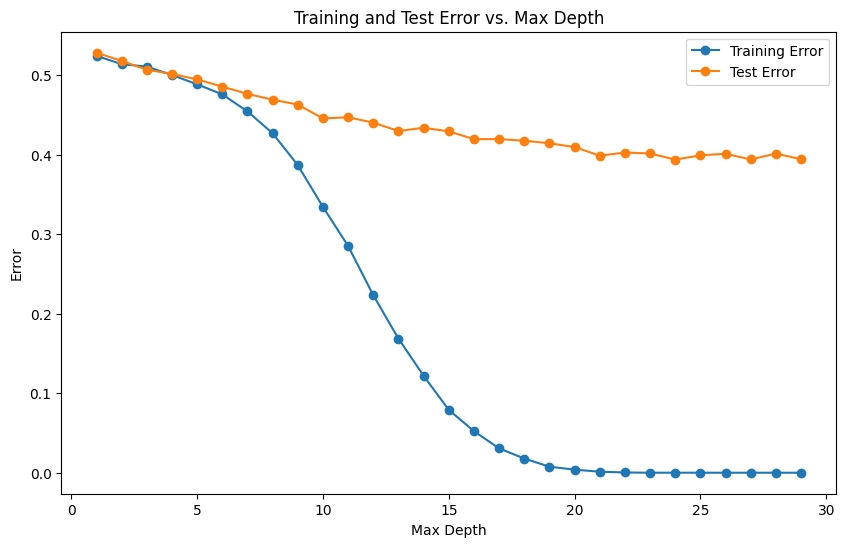

In [154]:
from sklearn.metrics import accuracy_score


max_depth_values = range(1, 30)

train_errors = []
test_errors = []

for max_depth in max_depth_values:
    model = RandomForestClassifier(max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_error = 1 - accuracy_score(y_train, y_train_pred)
    test_error = 1 - accuracy_score(y_test, y_test_pred)

    train_errors.append(train_error)
    test_errors.append(test_error)

plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, train_errors, label='Training Error', marker='o')
plt.plot(max_depth_values, test_errors, label='Test Error', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Error')
plt.title('Training and Test Error vs. Max Depth')
plt.legend()
plt.show()

## Построение и визуализация ROC-кривых

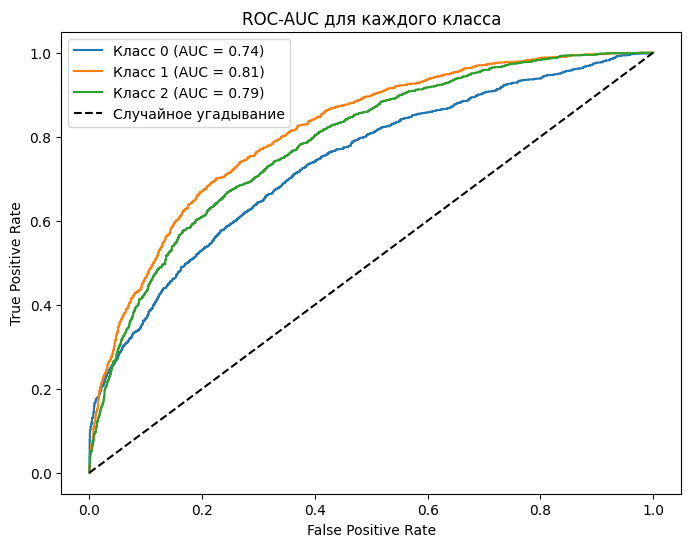

In [155]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


y_pred_proba = best_model.predict_proba(X_test)

y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

plt.figure(figsize=(8,6))

for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Класс {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label="Случайное угадывание")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC для каждого класса")
plt.legend()
plt.show()

## Обучение других моделей

------

## Обучение XGBClassifier

In [156]:
from xgboost import XGBClassifier

In [157]:
model_2 = XGBClassifier()
parametrs_2 = {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.05, 0.1]}

In [158]:
grid_search_clf_2 = GridSearchCV(model_2, parametrs_2, cv=5)
grid_search_clf_2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...ne,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300]})

In [159]:
grid_search_clf_2.best_params_

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}

In [160]:
best_model_2 = grid_search_clf_2.best_estimator_

In [161]:
best_model_2.score(X_train, y_train)

0.9313311688311688

In [162]:
best_model_2.score(X_test, y_test)

0.5803030303030303

In [163]:
y_pred_2 = best_model_2.predict(X_test)

In [164]:
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       0.57      0.52      0.54      1541
           1       0.61      0.61      0.61      1508
           2       0.56      0.62      0.59      1571

    accuracy                           0.58      4620
   macro avg       0.58      0.58      0.58      4620
weighted avg       0.58      0.58      0.58      4620



## Обучение мультиклассовой логистической регрессии

In [165]:
from sklearn.linear_model import LogisticRegression

In [166]:
model_3 = LogisticRegression()
parametrs_3 = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1'], 'solver': ['saga']}

In [167]:
grid_search_clf_3 = GridSearchCV(model_3, parametrs_3, cv=5)
grid_search_clf_3.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1'],
                         'solver': ['saga']})

In [168]:
grid_search_clf_3.best_params_

{'C': 10, 'penalty': 'l1', 'solver': 'saga'}

In [169]:
best_model_3 = grid_search_clf_3.best_estimator_

In [170]:
best_model_3.score(X_train, y_train)

0.48403679653679654

In [171]:
best_model_3.score(X_test, y_test)

0.49783549783549785

In [172]:
y_pred_3 = best_model_3.predict(X_test)

In [173]:
print(classification_report(y_test, y_pred_3))

              precision    recall  f1-score   support

           0       0.48      0.55      0.51      1541
           1       0.50      0.50      0.50      1508
           2       0.52      0.44      0.48      1571

    accuracy                           0.50      4620
   macro avg       0.50      0.50      0.50      4620
weighted avg       0.50      0.50      0.50      4620

